# Defacing pre-registration - Statistical analysis in R

We are running simulations order to evaluate how many missing values we are able to handle. The goal is to determine the maximum number of missing values before the model stops converging. We start with all the raters rating all the subjects and iteratively droping subjects.

#### Function to simulate data with missing values

In [11]:
simulate_data <- function(n_rated, n_sub, n_rater, perc_biased){
    #Set random seed
    set.seed(1234)

    manual_original <- matrix(, nrow = n_sub, ncol = n_rater)
    manual_defaced <- matrix(, nrow = n_sub, ncol = n_rater)

    for (i in 1:n_rater) {
        #Each rater rates subjects picked at random
        ind_sub <- sample(1:n_sub, n_rated, replace = F)
        #random original ratings sampled from {1,2,3,4}
        ratings <- sample(1:4, n_rated, replace = T)
        manual_original[ind_sub, i] <- ratings

        #To simulate a positive bias towards defaced data, we improve the ratings of a 
        #predefined percentage of the original scans
        ind_rat <- sample(1:n_rated, round(n_rated*perc_biased[i]/100), replace = F)
        ratings_biased <- ratings
        ratings_biased[ind_rat] <- ratings_biased[ind_rat] + 1
        #The scale stops at 4 so clip higher values to 4 
        ratings_biased[ratings_biased == 5] <- 4

        #Set the biased ratings as the ratings on the defaced condition
        manual_defaced[ind_sub, i] <- ratings_biased
    }

    manual_original_vec <- c(manual_original)
    manual_defaced_vec <- c(manual_defaced)

    defaced <- rep(c(0, 1), times = n_rater*n_sub)
    sub <- rep(rep(1:n_sub, each=2), times = n_rater)
    rater <- rep(1:n_rater, each=n_sub*2)

    #Convert to dataframe to use in regression
    df <- data.frame(sub = sub)
    df$defaced <- factor(defaced, levels = 0:1, labels = c("original", "defaced"))
    df$rater <- factor(rater, levels = 1:n_rater, labels = sprintf("rater%02d", 1:n_rater))
    df$ratings <- factor(c(rbind(manual_original_vec, manual_defaced_vec)), levels = 1:4, labels = c("excluded", "poor", "good", "excellent"))

    #Write dataframe to file
    saveRDS(df,file=sprintf("SimulatedData/SimulatedDefacedRatings_%.2fMissing.Rda",(n_sub-n_rated)/n_sub*100))

    return(df)
}

#### Run lmer on dataset with missing values

boundary (singular) fit: see ?isSingular



[1] "_______________0.00 missing values__________"
[1] "_______________8.62 missing values__________"


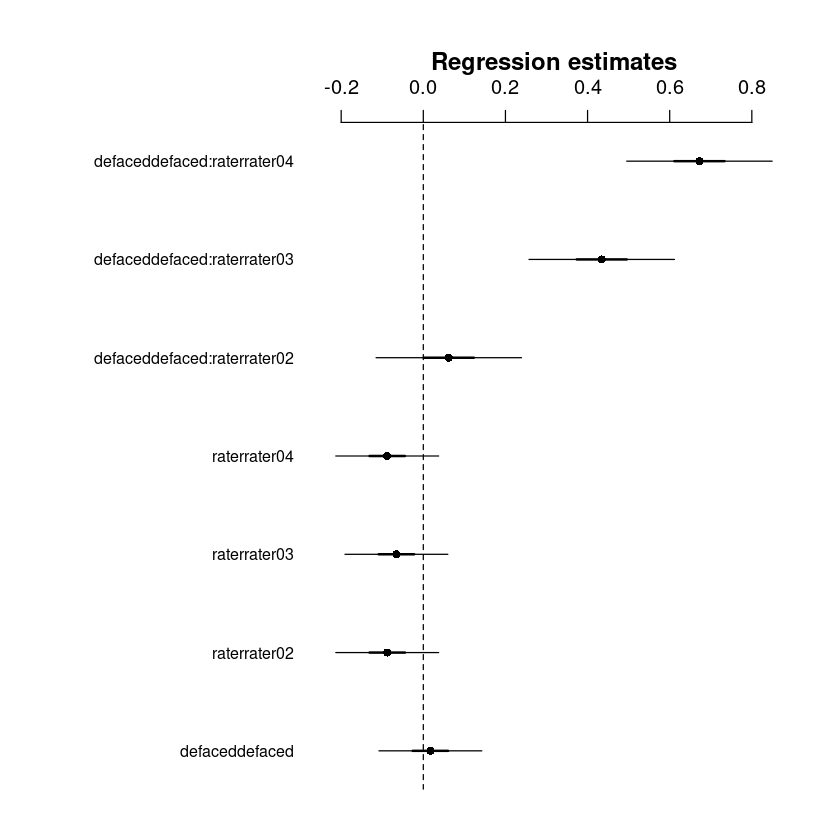

[1] "_______________17.24 missing values__________"


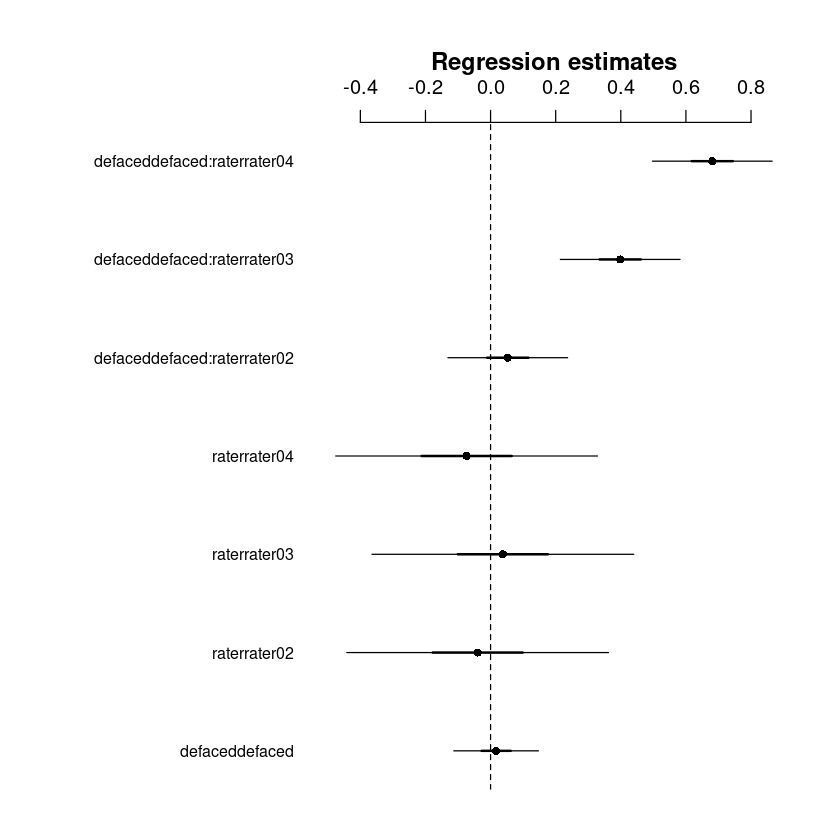

[1] "_______________25.86 missing values__________"


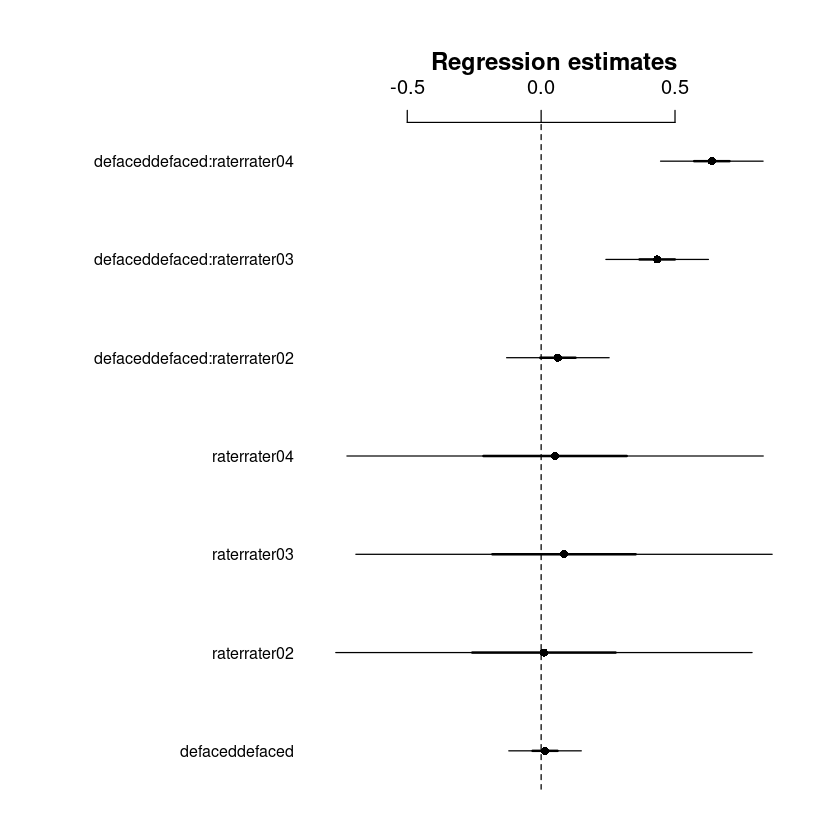

[1] "_______________34.48 missing values__________"


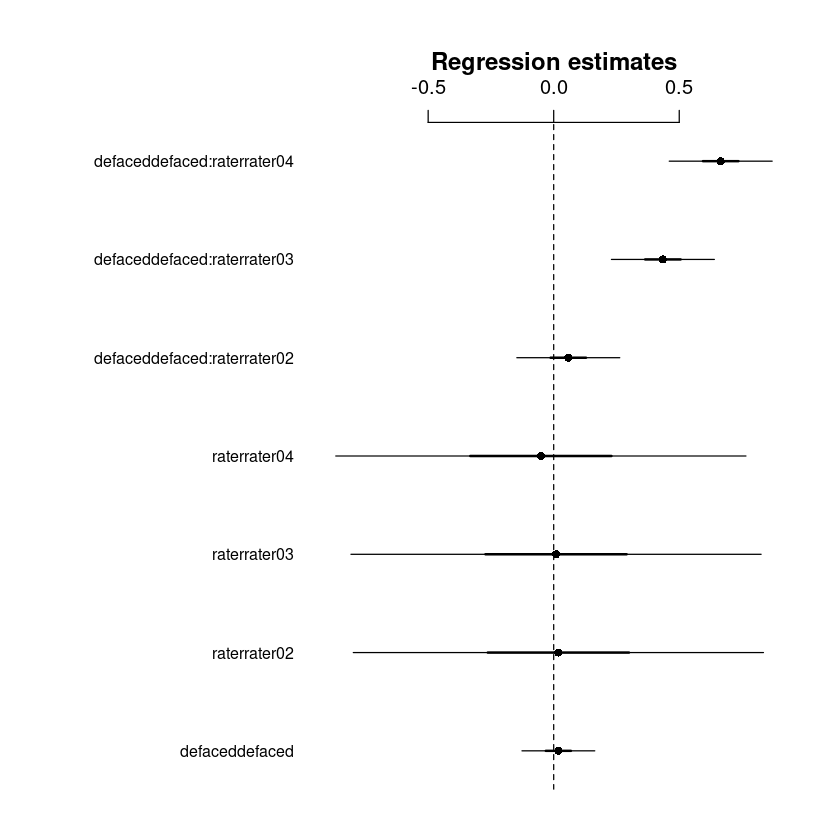

[1] "_______________43.10 missing values__________"


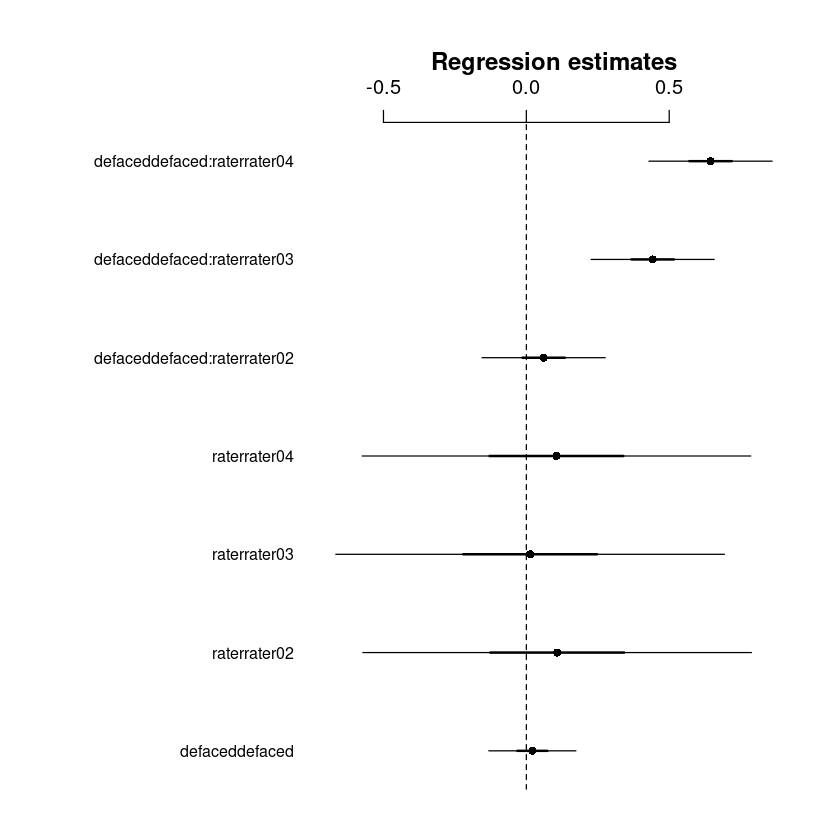

[1] "_______________51.72 missing values__________"


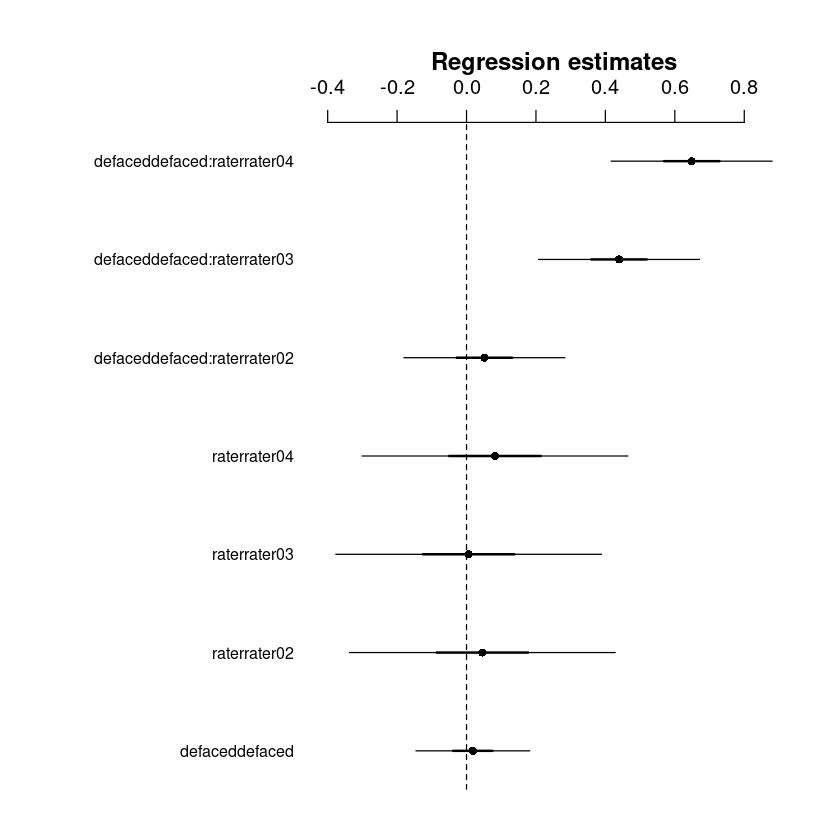

[1] "_______________60.34 missing values__________"


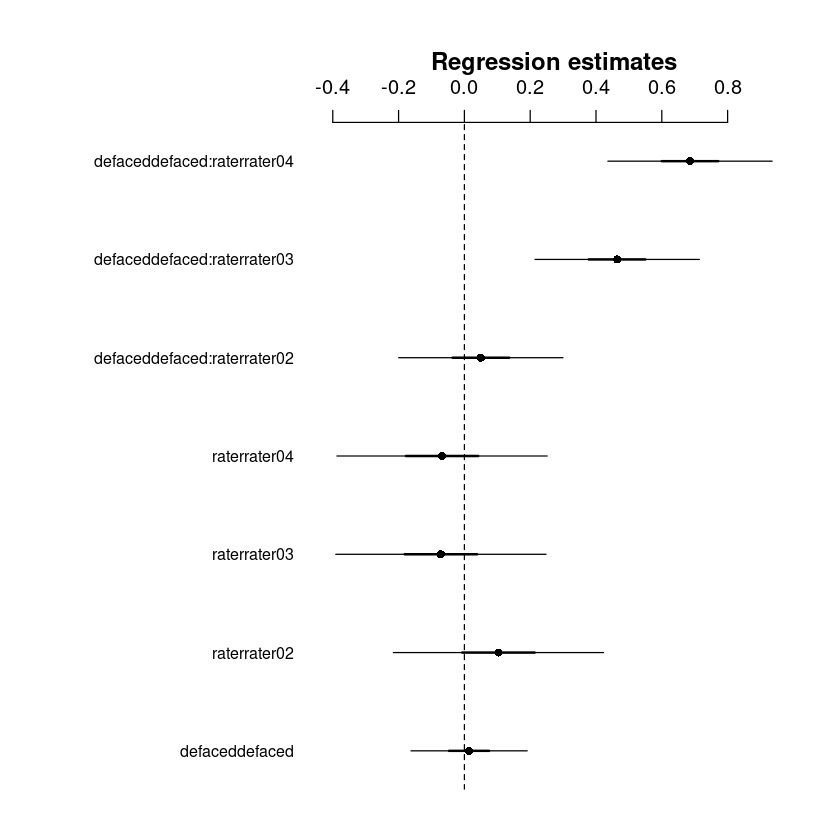

[1] "_______________68.97 missing values__________"


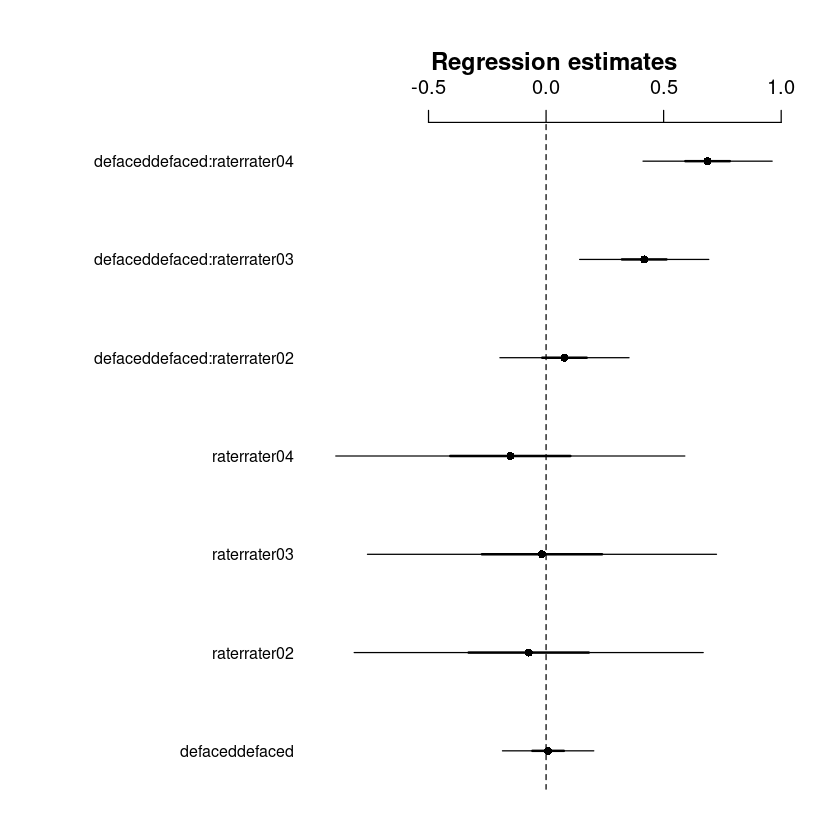

[1] "_______________77.59 missing values__________"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


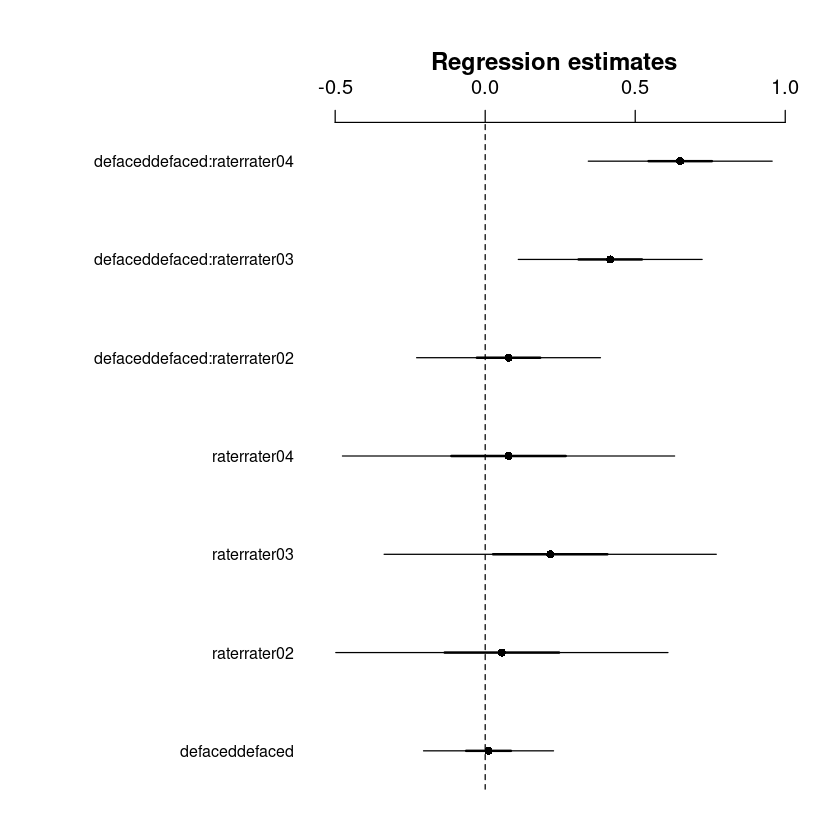

[1] "_______________86.21 missing values__________"


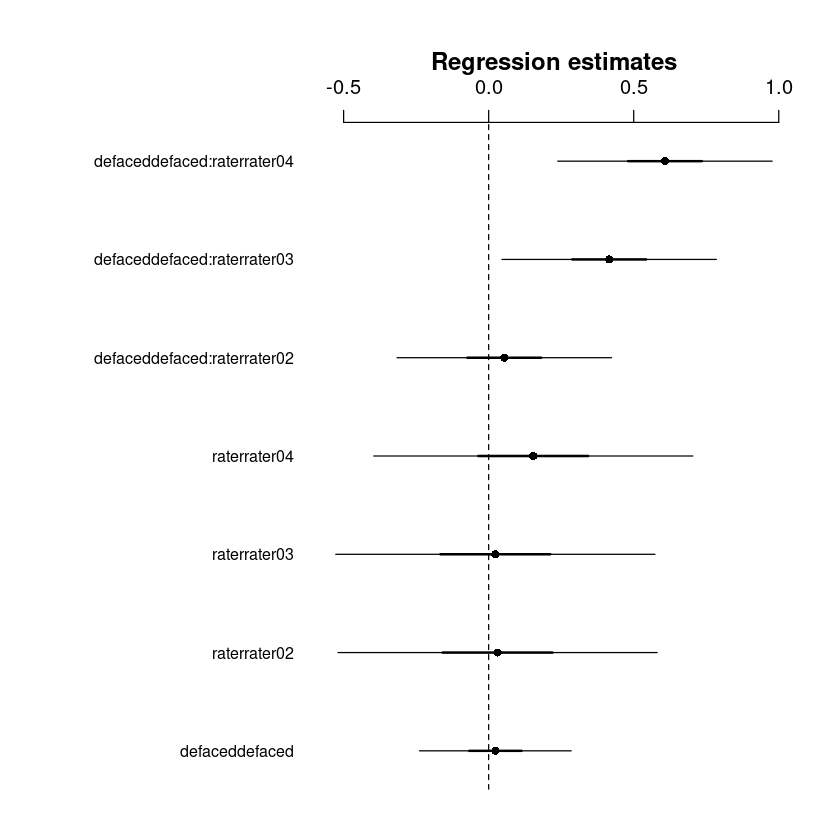

[1] "_______________94.83 missing values__________"


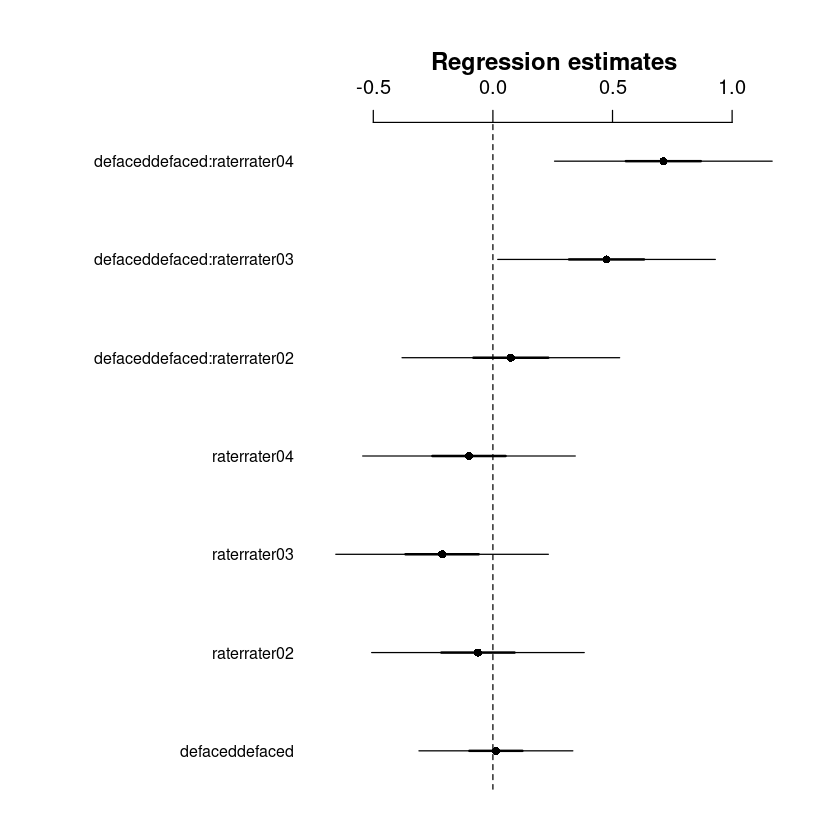

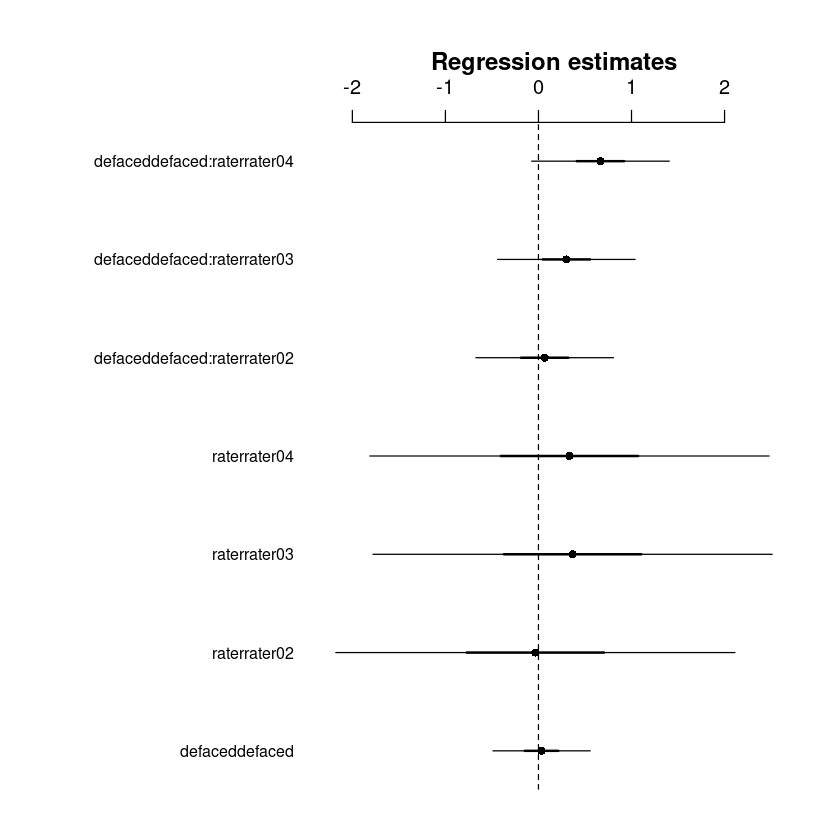

In [17]:
n_sub <- 580 #nbr of subjects available in the dataset
n_drop <- 50
n_rater <- 4 #nbr of raters
#Define for each rater the percentage of biased ratings
perc_biased <- c(2,10,60,90)

library(coefplot2)

for (j in seq(0, n_sub, by=n_drop)){
    df <- simulate_data(n_sub-j, n_sub, n_rater, perc_biased)
    
    library(lme4)
    fm1 <- lmer(as.numeric(ratings) ~ defaced*rater + (1 | rater), data=df, na.action=na.omit, REML = TRUE)
    
    print(sprintf("_______________%.02f missing values__________", j*100/n_sub))
    #print(summary(fm1)) 
    #print(ranef(fm1))
    
    ## Visualize fixed effect regression coefficients
    coefplot2(fm1)
}

### What does na.omit do ?

In [13]:
test <- matrix(,nrow=3 ,ncol=2)
test[1,2] <- 3
test[2,1] <- 4
test[2,2] <- 4
test[3,2] <- 6

na.exclude(test)

4,4


It discards a dataframe row when one value is missing.